In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from re import I

In [ ]:
# Load the dataset
data = pd.read_csv('bank.csv',delimiter=";",index_col=0)
data.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
age,,,,,,,,,,,,,,
30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,2,999,0,nonexistent,no
39,services,single,high.school,no,no,no,telephone,may,fri,4,999,0,nonexistent,no
25,services,married,high.school,no,yes,no,telephone,jun,wed,1,999,0,nonexistent,no
38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,3,999,0,nonexistent,no
47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,1,999,0,nonexistent,no


In [ ]:
X = data.drop(['y'], axis=1)
y = data['y']

# Data preprocessing
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
X_categorical = pd.get_dummies(X[categorical_cols], drop_first=True)

# Concatenate one-hot encoded categorical variables with numerical variables
X_processed = pd.concat([X.drop(categorical_cols, axis=1), X_categorical], axis=1)

# Handling missing values (you may need to adjust this based on the actual dataset)
# For simplicity, let's fill missing values with the mean for numerical columns
X_processed = X_processed.fillna(X_processed.mean())

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

## Task 1

In [ ]:
# a) Determine the out-of-bag-error and the error for the test dataset
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf_model.fit(X_train, y_train)
oob_error = 1 - rf_model.oob_score_
test_error = 1 - rf_model.score(X_test, y_test)
print(f"Out-of-bag error: {oob_error}")
print(f"Test error: {test_error}")

Out-of-bag error: 0.11107738998482553
Test error: 0.10922330097087374


### b) What does the out-of-bag-error describe?
Out-of-bag error is an estimate of the classification error obtained by aggregating predictions made on each training sample, using only the trees that do not contain that sample in their bootstrap sample.


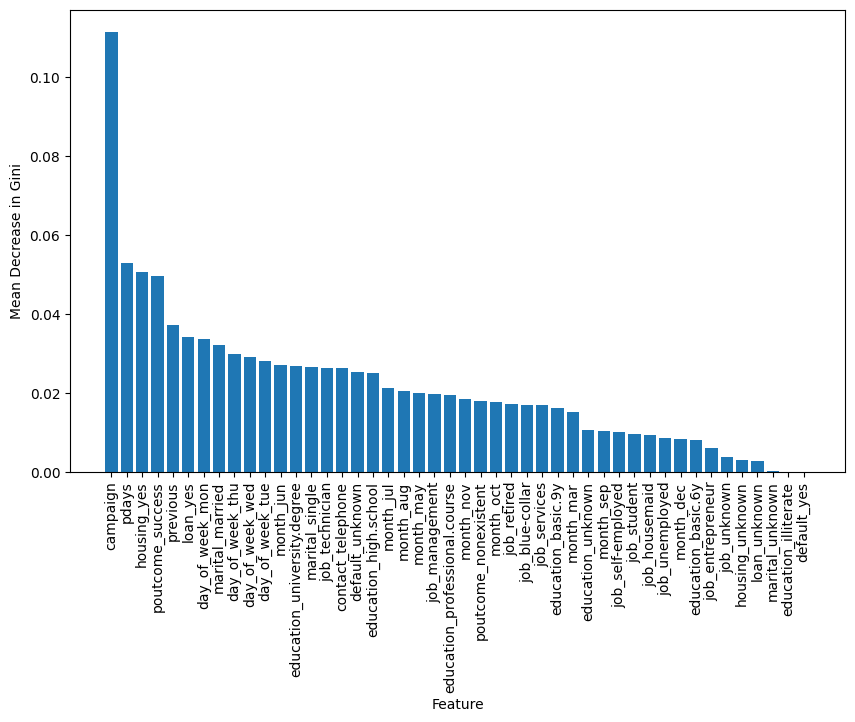

In [ ]:
# c) Determine the mean decrease in Gini for all features and plot it
feature_importances = rf_model.feature_importances_
feature_names = X_processed.columns
indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_processed.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_processed.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Mean Decrease in Gini")
plt.show()

In [ ]:
# d) Use the seven best attributes and create a new random forest
top_features = feature_names[indices][:7]
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Convert 'yes' and 'no' to binary labels (1 and 0) for the new dataset
y_train_binary = y_train.map({'no': 0, 'yes': 1})
y_test_binary = y_test.map({'no': 0, 'yes': 1})

# Create and train a new random forest model using the seven best attributes
rf_model_top = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_top.fit(X_train_top, y_train_binary)

RandomForestClassifier(random_state=42)

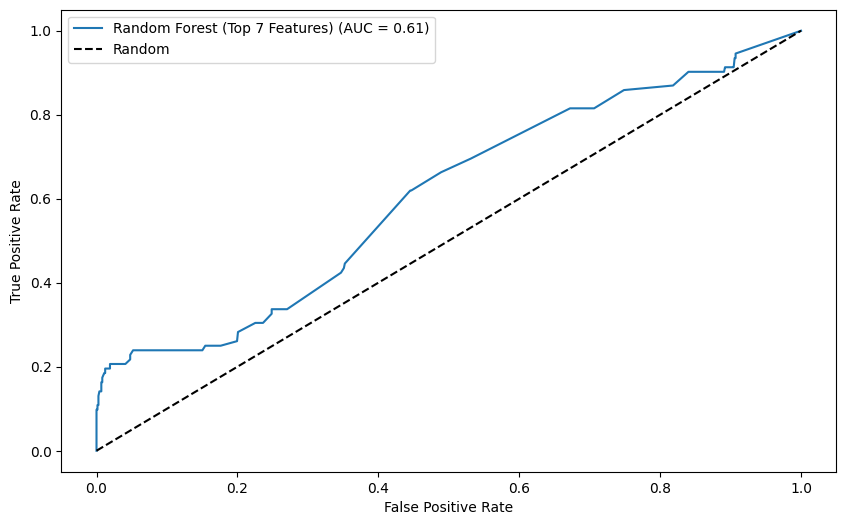

In [ ]:
# e) Plot an ROC curve for the classifier and determine the AUC value
y_prob_rf_top = rf_model_top.predict_proba(X_test_top)[:, 1]
fpr_rf_top, tpr_rf_top, _ = roc_curve(y_test_binary, y_prob_rf_top)
roc_auc_rf_top = auc(fpr_rf_top, tpr_rf_top)

# Continue with plotting and displaying the ROC curve for the new classifier
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf_top, tpr_rf_top, label=f"Random Forest (Top 7 Features) (AUC = {roc_auc_rf_top:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
# f) Which classifier provides better predictions and why?
y_prob_rf_top = rf_model_top.predict_proba(X_test_top)[:, 1]
fpr_rf_top, tpr_rf_top, _ = roc_curve(y_test_binary, y_prob_rf_top)
roc_auc_rf_top = auc(fpr_rf_top, tpr_rf_top)

if roc_auc_rf > roc_auc_rf_top:
    print("Random Forest provides better predictions.")
else:
    print("Random Forest (Top 7 Features) provides better predictions.")

Random Forest provides better predictions.


## Task 2

### a)
Precision and recall are important metrics, especially when dealing with imbalanced datasets. Precision measures the accuracy of positive predictions, while recall measures the ability of the classifier to capture all positive instances. In the context of task 1, where the goal is to predict the success of bank telemarketing, precision and recall would provide insights into the model's ability to correctly identify successful outcomes and avoid false positives.

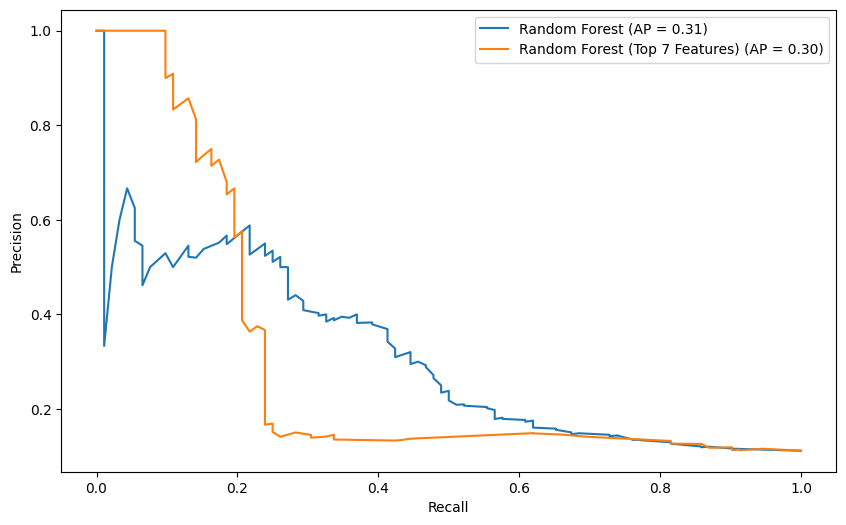

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# b) Calculate Precision and Recall for the original random forest model
precision_rf, recall_rf, _ = precision_recall_curve(y_test_binary, y_prob_rf)
average_precision_rf = average_precision_score(y_test_binary, y_prob_rf)

# Calculate Precision and Recall for the new random forest model with top features
precision_rf_top, recall_rf_top, _ = precision_recall_curve(y_test_binary, y_prob_rf_top)
average_precision_rf_top = average_precision_score(y_test_binary, y_prob_rf_top)

# Compare Precision-Recall Curve with ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_rf, precision_rf, label=f"Random Forest (AP = {average_precision_rf:.2f})")
plt.plot(recall_rf_top, precision_rf_top, label=f"Random Forest (Top 7 Features) (AP = {average_precision_rf_top:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix

# Convert predicted labels to binary format
y_pred_rf_series = pd.Series(y_pred_rf)
y_pred_rf_binary = y_pred_rf_series.map({'no': 0, 'yes': 1})

# Handle NaN values in y_pred_rf_top_binary (replace NaN with 0)
y_pred_rf_top_series = pd.Series(y_pred_rf_top)
y_pred_rf_top_binary = y_pred_rf_top_series.map({'no': 0, 'yes': 1}).fillna(0)

# Calculate metrics
accuracy_rf = accuracy_score(y_test_binary, y_pred_rf_binary)
f1_score_rf = f1_score(y_test_binary, y_pred_rf_binary)
mcc_rf = matthews_corrcoef(y_test_binary, y_pred_rf_binary)

accuracy_rf_top = accuracy_score(y_test_binary, y_pred_rf_top_binary)
f1_score_rf_top = f1_score(y_test_binary, y_pred_rf_top_binary)
mcc_rf_top = matthews_corrcoef(y_test_binary, y_pred_rf_top_binary)

# Print the results
print("Original Random Forest Model:")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"F1-Score: {f1_score_rf:.2f}")
print(f"Matthews Correlation Coefficient: {mcc_rf:.2f}")

print("\nRandom Forest Model with Top 7 Features:")
print(f"Accuracy: {accuracy_rf_top:.2f}")
print(f"F1-Score: {f1_score_rf_top:.2f}")
print(f"Matthews Correlation Coefficient: {mcc_rf_top:.2f}")


Original Random Forest Model:
Accuracy: 0.89
F1-Score: 0.31
Matthews Correlation Coefficient: 0.29

Random Forest Model with Top 7 Features:
Accuracy: 0.89
F1-Score: 0.00
Matthews Correlation Coefficient: 0.00
